In [1]:
import time
from enum import Enum
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans, KMeans, DBSCAN
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import PCA, LatentDirichletAllocation, NMF
from yellowbrick.cluster import KElbowVisualizer
from kneed import KneeLocator
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.svm import SVC

In [2]:
dataset = pd.read_csv('./cleaned_dataset.csv', converters={'Tags': lambda x: eval(x)})
dataset

Body  \
0      uiimageview already later second uiimageview u...   
1      requirement againstabout people allow close tr...   
2      gem inside rake task parse content dump contai...   
3      includes nested primary link sub menu item tas...   
4      done google searching custom django similar st...   
...                                                  ...   
75455  rid std vector boost ptr vector remove removed...   
75456            singleton factory domain factory around   
75457  wondering keep resharper removing directive pe...   
75458  started document developing apps iphone wanted...   
75459  area dot distributed area detect cluster dot a...   

                           Tags  
0                      [iphone]  
1                [c#, winforms]  
2                   [ruby, xml]  
3                         [php]  
4         [python, sql, django]  
...                         ...  
75455                     [c++]  
75456                    [java]  
75457  [c#, visual-studio-2008]  
75458                  [iphone]  
75459               [algorithm]  

[75460 rows x 2 columns]

# Vectorizing data

Plusieurs méthodes nous permettent de transformer ce bag-of-words en données numérique. Nous allons créer une fonction de preprocessing permettant de la choisir, afin de les tester de manières indépendantes.

In [4]:
class Algorithm(Enum):
    KMeans = 'kmeans'
    MiniBatchKmeans = 'minikmeans'
    DBSCAN = 'dbscan'


class Vectorizer(Enum):
    Count = 'count'
    TfIdf = 'tf-idf'


def preprocessing(dataset: pd.DataFrame, vectorizer: Vectorizer):
    """ Add features engineering to the dataset """
    max_features = 3000

    # CountVectorizer
    if vectorizer == Vectorizer.Count:
        count_vectorizer = CountVectorizer(lowercase=False, max_features=max_features)
        count_matrix = count_vectorizer.fit_transform(dataset['Body'])
        df = pd.DataFrame(count_matrix.toarray(), index=dataset.index,
                          columns=count_vectorizer.get_feature_names_out())
        df.reset_index(inplace=True, drop=True)

    # Tf-Idf
    elif vectorizer == Vectorizer.TfIdf:
        tf_vectorizer = TfidfVectorizer(lowercase=False, max_features=max_features)
        tf_matrix = tf_vectorizer.fit_transform(dataset['Body'])
        df = pd.DataFrame(tf_matrix.toarray(), index=dataset.index,
                          columns=tf_vectorizer.get_feature_names_out())
        df.reset_index(inplace=True, drop=True)

    n_components = 500
    pca = PCA(n_components=n_components)
    df_projected = pca.fit_transform(df)
    return (df_projected, df)


In [5]:
vectors = {name: preprocessing(dataset, vectorizer) for name, vectorizer in Vectorizer.__members__.items()}

# Unsupervized clustering

## KMeans
Pour ce test, nous utiliserons la version `MiniBatchKMeans` qui donne des résultats similaires mais permet une exécution beaucoup plus rapide. Nous passerons sur KMeans pour la production.

In [6]:
def kmeans_clusters(X):
    kelbow_viz = KElbowVisualizer(MiniBatchKMeans(random_state=5), k=(16, 24))
    kelbow_viz.fit(X)
    kelbow_viz.show()
    print(f'kelbow: {kelbow_viz.elbow_value_}')

    kmeans = MiniBatchKMeans(kelbow_viz.elbow_value_, random_state=5)
    kmeans.fit(X)
    labels = pd.Series(kmeans.labels_, name='cluster-label')
    value_dict = dict(labels.value_counts())
    value_counts = {str(k): int(v) for k, v in value_dict.items()}
    display(pd.Series(value_counts, name='clusters-size'))
    return labels

KMeans with Count


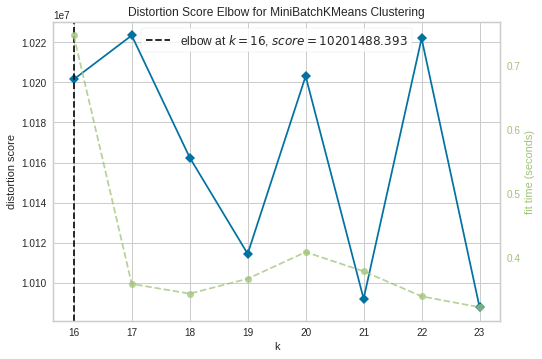

kelbow: 16


12    64070
2      1410
4      1348
13     1075
14      984
3       971
0       825
10      788
1       712
15      680
8       652
6       585
11      561
5       531
9       246
7        22
Name: clusters-size, dtype: int64

Execution time: 4.653792381286621s
KMeans with TfIdf


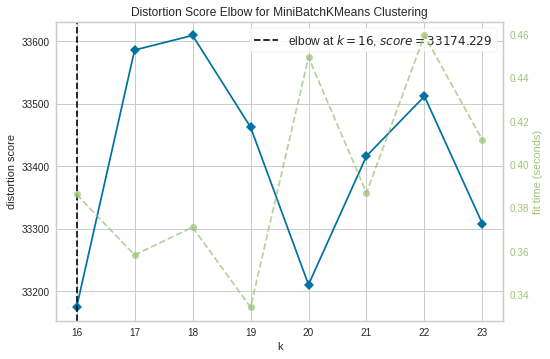

kelbow: 16


11    67518
14     1571
5      1423
8      1207
15     1042
1       856
6       698
7       257
0       211
4       186
2       136
9       114
13       97
12       92
3        39
10       13
Name: clusters-size, dtype: int64

Execution time: 4.354586839675903s


In [7]:
kmeans_labels = {}
for name, vector in vectors.items():
    print(f'KMeans with {name}')
    start = time.time()
    kmeans_labels[name] = kmeans_clusters(vector[0])
    print(f'Execution time: {time.time() - start}s')


### Visualisation

In [8]:
import nltk

def get_top_tags(df, label, nb_tags=5):
    tagsFreq = df[df['cluster_label'] == label]['tags'].to_frame().apply(lambda x : pd.Series([x['tags'], nltk.FreqDist(x['tags'])], index=['tokens', 'frequency']), axis=1, result_type='expand')
    total_freq = {}
    for dictionnary in tagsFreq['frequency']:
        for k,v in dictionnary.items():
            if k in total_freq:
                total_freq[k] += v
            else:
                total_freq[k] = v

    freq_list = sorted(total_freq.items(), key=lambda x: x[1], reverse=True)
    return freq_list[:nb_tags]

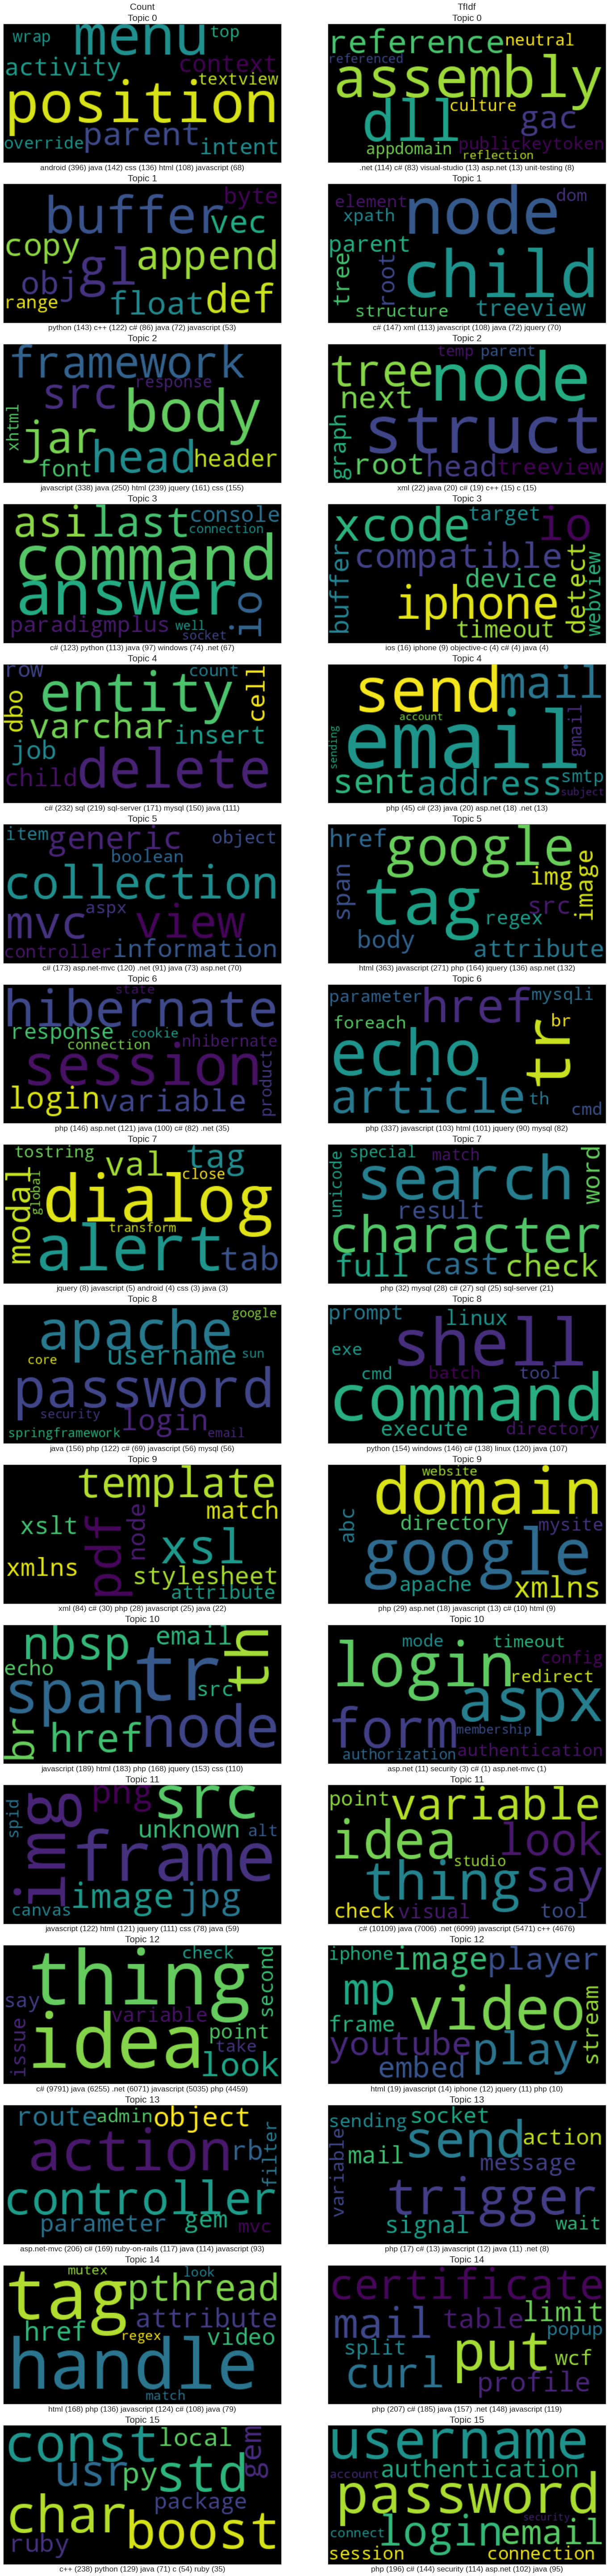

In [9]:
from wordcloud import WordCloud
n_cols = 2
n_rows = max([serie.max() for serie in kmeans_labels.values()]) + 1
fig = plt.figure(constrained_layout=True, figsize=(n_cols * 10 , n_rows * 5))
subfigures = fig.subfigures(1, len(kmeans_labels))
for vect_idx, (name, label) in enumerate(kmeans_labels.items()):
    dataset_labels = vectors[name][1].assign(cluster_label=label,
                           tags=dataset['Tags'])
    cluster_sum = dataset_labels.groupby('cluster_label').sum()
    subfigures[vect_idx].suptitle(name, fontsize='xx-large')
    for label_idx, label in enumerate(cluster_sum.index):
        top10_topics = cluster_sum.loc[label]\
                .sort_values(ascending=False)\
                .head(10).index.to_list()
        ax = subfigures[vect_idx].add_subplot(n_rows, 1, label_idx + 1)
        ax.set_title(f'Topic {label}', fontsize='xx-large')
        cloud = WordCloud().generate(' '.join(top10_topics))
        ax.imshow(cloud, interpolation='bilinear')
        ax.grid(False)
        ax.tick_params(axis='both', left=False, bottom=False, labelbottom=False, labelleft=False)
        ax.set_xlabel(' '.join([f'{tag} ({count})' for (tag, count) in get_top_tags(dataset_labels, label)]), fontsize='x-large')

plt.show()


### Scoring

In [10]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

for (name, vector), (_, labels) in zip(vectors.items(), kmeans_labels.items()):
    print(f'{name} Silhouette score : {silhouette_score(vector[0], labels)}')
    print(f'{name} Calinski-Harabasz score : {calinski_harabasz_score(vector[0], labels)}')
    print(f'{name} Davies-Bouldin score : {davies_bouldin_score(vector[0], labels)}')
    

Count Silhouette score : 0.23380253285579056
Count Calinski-Harabasz score : 133.26836546232386
Count Davies-Bouldin score : 5.895288772643976
TfIdf Silhouette score : 0.00834822900070291
TfIdf Calinski-Harabasz score : 123.5672303365869
TfIdf Davies-Bouldin score : 4.020484347499055


## DBSCAN

In [11]:
def make_dbscan_clusters(X):
    # Need to sample to avoid too much resources comsuption
    X_sample = X[0:30000]
    nb_neighbors = 10
    nearest_neighbors = NearestNeighbors(n_neighbors=nb_neighbors)
    nearest_neighbors.fit(X_sample)
    distances, _ = nearest_neighbors.kneighbors(X_sample)

    # Get max distance between neighbors
    max_distances = np.sort(distances[:, nb_neighbors - 1])

    # Find an elbow
    index = np.arange(len(max_distances))
    knee = KneeLocator(index, max_distances, curve='convex',
                       direction='increasing', interp_method='polynomial')
    knee.plot_knee(figsize=(10, 10))
    plt.xlabel("Points")
    plt.ylabel("Distance")
    plt.show()

    dbscan = DBSCAN(min_samples=100, eps=knee.elbow_y)
    dbscan.fit(X_sample)
    print(f'Nombre de clusters : {len(dbscan.labels_)}')
    labels = pd.Series(dbscan.labels_, name='cluster-label')
    value_dict = dict(labels.value_counts())
    value_counts = {str(k): int(v) for k, v in value_dict.items()}
    display(pd.Series(value_counts, name='clusters-size'))
    return labels

DBSCAN with Count


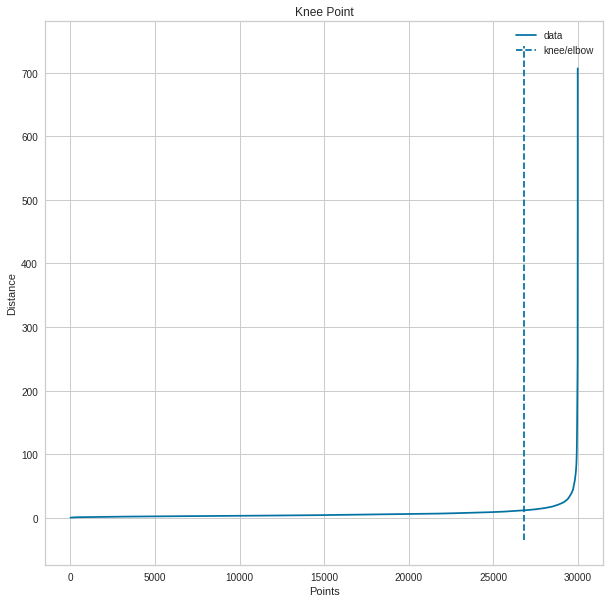

Nombre de clusters : 30000


0     27389
-1     2611
Name: clusters-size, dtype: int64

DBSCAN with TfIdf


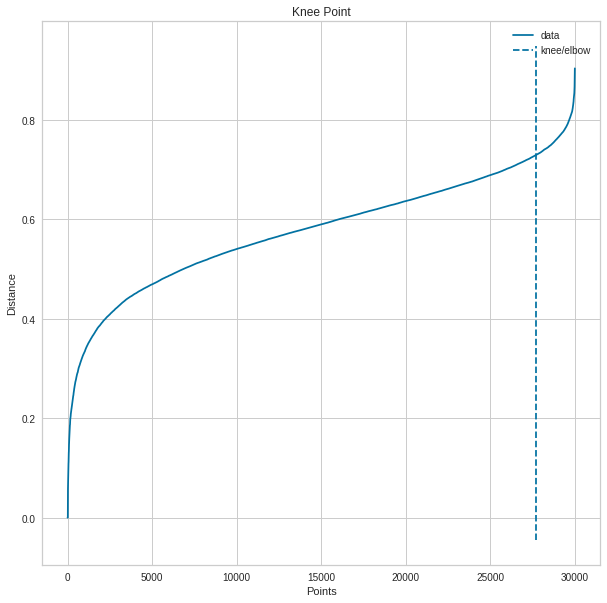

Nombre de clusters : 30000


0     29482
-1      518
Name: clusters-size, dtype: int64

In [12]:
dbscan_labels = {}
for name, vector in vectors.items():
    print(f'DBSCAN with {name}')
    dbscan_labels[name] = make_dbscan_clusters(vector[0])

DBSCAN ne semble pas à l'aise avec ces données et nécessite une puissance bien plus grande que KMeans. Nous allons donc le laisser de côté.

## Latent Dirichlet Allocation (LDA)

In [13]:
%%time
# Fix the number of topics near the KMeans elbow
no_topics = 17
lda = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online',
                                         learning_offset=50., random_state=0).fit(vectors['Count'][1])

CPU times: user 47.7 s, sys: 42.4 ms, total: 47.8 s
Wall time: 47.9 s


### Visualization

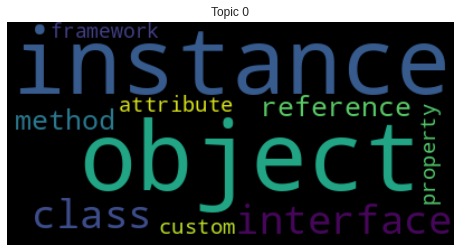

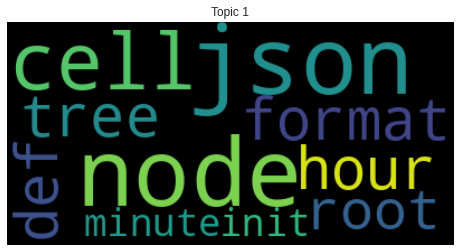

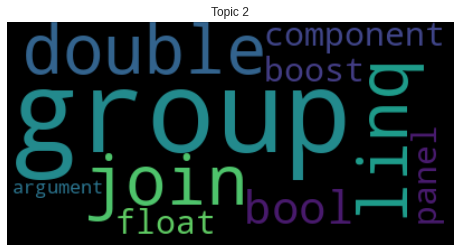

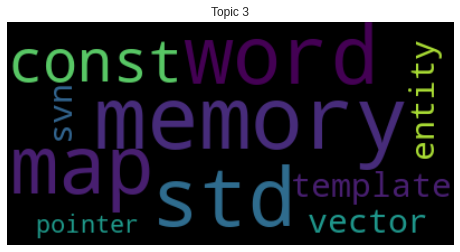

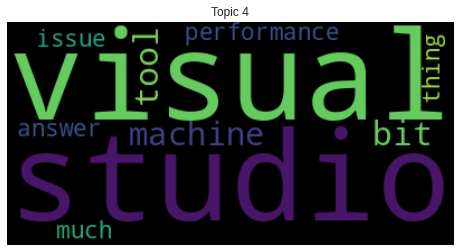

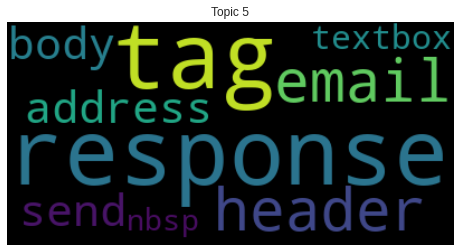

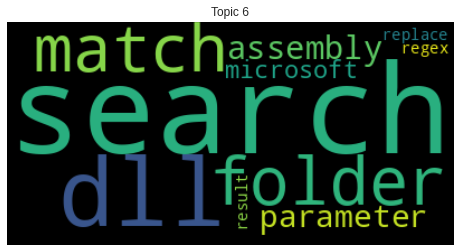

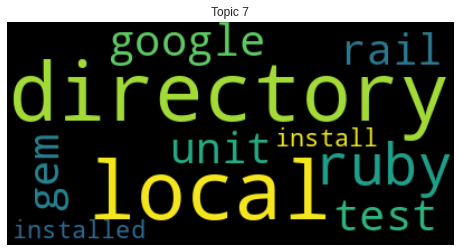

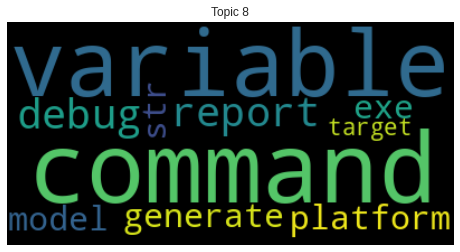

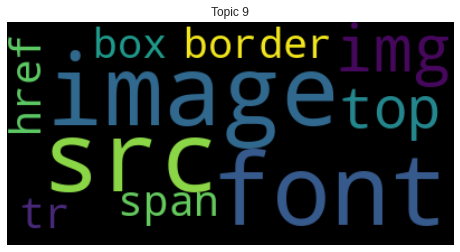

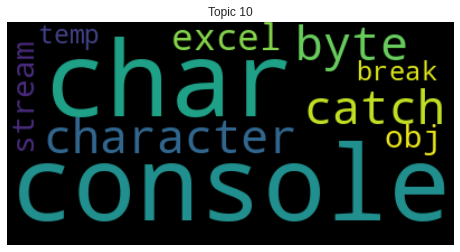

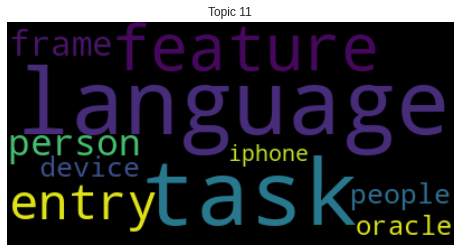

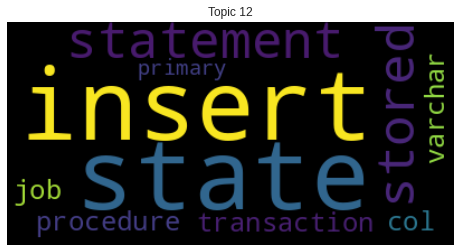

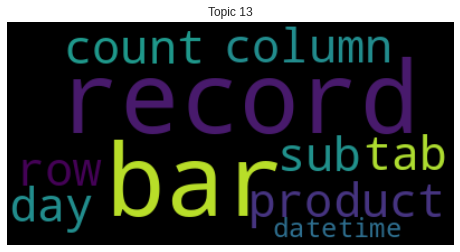

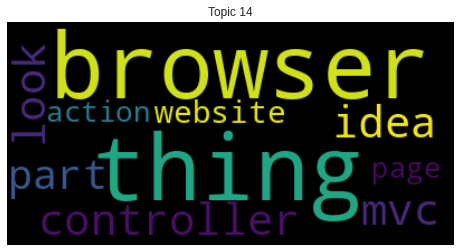

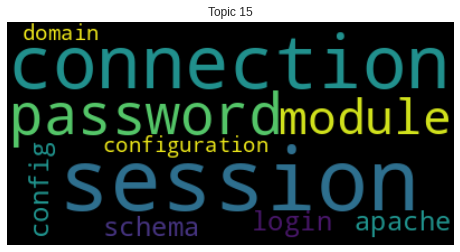

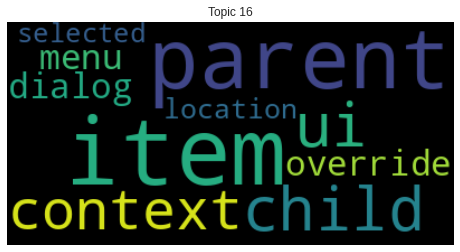

In [14]:
no_top_words = 10
for topic_idx, topic in enumerate(lda.components_):
    cloud = WordCloud().generate(" ".join([vectors['Count'][1].columns[i]
                    for i in topic.argsort()[:-no_top_words - 1:-1]]))
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Topic {topic_idx}')
    plt.show()


## Scoring

In [15]:
print(f'Log-likelihood: {lda.score(vectors["Count"][1])}')
print(f'Perplexity: {lda.perplexity(vectors["Count"][1])}')

Log-likelihood: -19405699.939249236
Perplexity: 1465.2640314830094
